In [1]:
!pip install kaggle --upgrade --quiet

import os
import random
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np


In [2]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
!kaggle datasets download -d "dansbecker/food-101" -p "/content/drive/MyDrive/KaggleDatasets/food-101"

Dataset URL: https://www.kaggle.com/datasets/dansbecker/food-101
License(s): other
100% 9.38G/9.38G [07:22<00:00, 24.0MB/s]
100% 9.38G/9.38G [07:22<00:00, 22.8MB/s]


In [ ]:
!unzip "/content/drive/MyDrive/KaggleDatasets/food-101/food-101.zip"

In [5]:
import random

class Food101Dataset(Dataset):
    def __init__(self, dataset_directory, split, transform=None, max_image_count=None):

        self.dataset_directory = dataset_directory
        self.image_directory = os.path.join(dataset_directory, "images")
        self.transform = transform

        #Load the split file(either gonna be train or test)
        split_file = os.path.join(dataset_directory, f"meta/{split}.txt")
        with open(split_file, "r") as file:
            self.img_paths = file.read().splitlines()

        #Limit dataset (10k instead of 100k)
        if max_image_count is not None:
            self.img_paths = random.sample(self.img_paths, min(max_image_count, len(self.img_paths)))

        #Load class names
        class_file = os.path.join(dataset_directory, "meta/classes.txt")
        with open(class_file, "r") as file:
            self.classes = file.read().splitlines()

        #Map class names to numeric labels
        self.class_index_mapping = {}
        for index, cls_name in enumerate(self.classes):
            self.class_index_mapping[cls_name] = index

    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, index):
        relative_path = self.img_paths[index]
        class_name = os.path.dirname(relative_path)
        label = self.class_index_mapping[class_name]

        img_path = os.path.join(self.image_directory, relative_path + ".jpg")
        img = Image.open(img_path).convert("RGB")

        if self.transform:
            img = self.transform(img)

        return img, label


In [6]:
# Data augmentations for training
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomCrop((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(30),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# For test/validation, only resizing and normalization
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

dataset_directory = "/content/food-101/food-101"
train_dataset = Food101Dataset(dataset_directory="/content/food-101/food-101", split="train", transform=train_transforms, max_image_count=8000)
test_dataset = Food101Dataset(dataset_directory="/content/food-101/food-101", split="test", transform=test_transforms, max_image_count=2000)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

num_classes = len(train_dataset.classes)
print("Number of classes:", num_classes)
print("Train samples:", len(train_dataset))
print("Test samples:", len(test_dataset))


Number of classes: 101
Train samples: 8000
Test samples: 2000


/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:617: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [7]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

#load up mobilenet
model = models.mobilenet_v2(pretrained=True)

# freeze base model layers, keeps pre-trained features from imagenet
for param in model.parameters():
    param.requires_grad = False

#replace the final layer for Food101 classes instead of the 1000 in imagenet
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

model = model.to(device)


Using device: cuda


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v2-b0353104.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v2-b0353104.pth
100%|██████████| 13.6M/13.6M [00:00<00:00, 69.9MB/s]


In [8]:
from tqdm import tqdm  # for the loadingbar

def train_one_epoch(model, loader, criterion, optimizer, epoch, total_epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    # tqdm progress bar
    progress_bar = tqdm(enumerate(loader), total=len(loader), desc=f"Epoch [{epoch}/{total_epochs}]")

    for batch_index, (images, labels) in progress_bar:
        images, labels = images.to(device), labels.to(device)

        #Forward pass
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)

        #Backward pass and optimization
        loss.backward()
        optimizer.step()

        #Save info
        running_loss += loss.item() * images.size(0)
        _, predictions = outputs.max(1)
        correct += predictions.eq(labels).sum().item()
        total += labels.size(0)

        progress_bar.set_postfix({
            "Batch Loss": loss.item(),
            "Running Loss": running_loss / total,
            "Accuracy": 100.0 * correct / total
        })

    epoch_loss = running_loss / len(loader.dataset)
    epoch_acc = correct / len(loader.dataset)
    return epoch_loss, epoch_acc

def evaluate(model, loader, criterion):
    model.eval()  # Set model to evaluation mode, consistent behavior
    running_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():  #No need to track gradients during evaluation
        for images, labels in loader: # go through batches
            images, labels = images.to(device), labels.to(device) # move to right device
            outputs = model(images) # predict current batch
            loss = criterion(outputs, labels) #calc loss

            running_loss += loss.item() * images.size(0)
            _, predictions = outputs.max(1)
            correct += predictions.eq(labels).sum().item()
            total += labels.size(0)

    epoch_loss = running_loss / total
    epoch_acc = correct / total
    return epoch_loss, epoch_acc


In [9]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)
#Metrics
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
best_acc = 0.0
# training loop
num_epochs = 30
for epoch in range(1, num_epochs + 1):
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, epoch, num_epochs)
    val_loss, val_acc = evaluate(model, test_loader, criterion)

    # Append metrics to the lists
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch {epoch}/{num_epochs}:")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save the best model checkpoint
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_acc': best_acc
        }, "best_model_checkpoint.pth")

Epoch [1/30]: 100%|██████████| 250/250 [00:50<00:00,  4.99it/s, Batch Loss=3.22, Running Loss=3.77, Accuracy=17.8]


Epoch 1/30:
Train Loss: 3.7712, Train Acc: 0.1777
Val Loss: 2.9757, Val Acc: 0.3015


Epoch [2/30]: 100%|██████████| 250/250 [00:45<00:00,  5.50it/s, Batch Loss=2.24, Running Loss=2.73, Accuracy=35.6]


Epoch 2/30:
Train Loss: 2.7312, Train Acc: 0.3558
Val Loss: 2.5271, Val Acc: 0.3845


Epoch [3/30]: 100%|██████████| 250/250 [00:45<00:00,  5.52it/s, Batch Loss=1.86, Running Loss=2.39, Accuracy=41.1]


Epoch 3/30:
Train Loss: 2.3932, Train Acc: 0.4113
Val Loss: 2.3802, Val Acc: 0.4215


Epoch [4/30]: 100%|██████████| 250/250 [00:44<00:00,  5.64it/s, Batch Loss=2.48, Running Loss=2.24, Accuracy=44.8]


Epoch 4/30:
Train Loss: 2.2399, Train Acc: 0.4481
Val Loss: 2.4393, Val Acc: 0.4040


Epoch [5/30]: 100%|██████████| 250/250 [00:45<00:00,  5.54it/s, Batch Loss=2.6, Running Loss=2.15, Accuracy=45.8]


Epoch 5/30:
Train Loss: 2.1498, Train Acc: 0.4577
Val Loss: 2.3261, Val Acc: 0.4320


Epoch [6/30]: 100%|██████████| 250/250 [00:45<00:00,  5.47it/s, Batch Loss=1.98, Running Loss=2.08, Accuracy=47]


Epoch 6/30:
Train Loss: 2.0766, Train Acc: 0.4695
Val Loss: 2.2669, Val Acc: 0.4330


Epoch [7/30]: 100%|██████████| 250/250 [00:45<00:00,  5.49it/s, Batch Loss=1.86, Running Loss=1.99, Accuracy=49.4]


Epoch 7/30:
Train Loss: 1.9858, Train Acc: 0.4938
Val Loss: 2.3195, Val Acc: 0.4435


Epoch [8/30]: 100%|██████████| 250/250 [00:45<00:00,  5.52it/s, Batch Loss=1.87, Running Loss=1.96, Accuracy=50]


Epoch 8/30:
Train Loss: 1.9641, Train Acc: 0.4995
Val Loss: 2.3220, Val Acc: 0.4420


Epoch [9/30]: 100%|██████████| 250/250 [00:44<00:00,  5.59it/s, Batch Loss=2.21, Running Loss=1.91, Accuracy=50.7]


Epoch 9/30:
Train Loss: 1.9099, Train Acc: 0.5071
Val Loss: 2.2819, Val Acc: 0.4400


Epoch [10/30]: 100%|██████████| 250/250 [00:45<00:00,  5.50it/s, Batch Loss=2.61, Running Loss=1.88, Accuracy=51.5]


Epoch 10/30:
Train Loss: 1.8752, Train Acc: 0.5154
Val Loss: 2.2852, Val Acc: 0.4490


Epoch [11/30]: 100%|██████████| 250/250 [00:45<00:00,  5.52it/s, Batch Loss=2.23, Running Loss=1.86, Accuracy=51.3]


Epoch 11/30:
Train Loss: 1.8643, Train Acc: 0.5130
Val Loss: 2.3532, Val Acc: 0.4305


Epoch [12/30]: 100%|██████████| 250/250 [00:44<00:00,  5.61it/s, Batch Loss=2.09, Running Loss=1.85, Accuracy=52.1]


Epoch 12/30:
Train Loss: 1.8478, Train Acc: 0.5215
Val Loss: 2.2663, Val Acc: 0.4635


Epoch [13/30]: 100%|██████████| 250/250 [00:45<00:00,  5.54it/s, Batch Loss=2.07, Running Loss=1.81, Accuracy=51.9]


Epoch 13/30:
Train Loss: 1.8051, Train Acc: 0.5194
Val Loss: 2.2811, Val Acc: 0.4535


Epoch [14/30]: 100%|██████████| 250/250 [00:45<00:00,  5.47it/s, Batch Loss=2.54, Running Loss=1.81, Accuracy=53.4]


Epoch 14/30:
Train Loss: 1.8145, Train Acc: 0.5337
Val Loss: 2.2800, Val Acc: 0.4530


Epoch [15/30]: 100%|██████████| 250/250 [00:45<00:00,  5.48it/s, Batch Loss=1.62, Running Loss=1.77, Accuracy=53.3]


Epoch 15/30:
Train Loss: 1.7730, Train Acc: 0.5329
Val Loss: 2.3067, Val Acc: 0.4450


Epoch [16/30]: 100%|██████████| 250/250 [00:46<00:00,  5.37it/s, Batch Loss=2.29, Running Loss=1.77, Accuracy=53]


Epoch 16/30:
Train Loss: 1.7700, Train Acc: 0.5304
Val Loss: 2.2771, Val Acc: 0.4540


Epoch [17/30]: 100%|██████████| 250/250 [00:45<00:00,  5.49it/s, Batch Loss=1.76, Running Loss=1.76, Accuracy=53.4]


Epoch 17/30:
Train Loss: 1.7619, Train Acc: 0.5335
Val Loss: 2.3020, Val Acc: 0.4470


Epoch [18/30]: 100%|██████████| 250/250 [00:45<00:00,  5.48it/s, Batch Loss=1.44, Running Loss=1.75, Accuracy=52.9]


Epoch 18/30:
Train Loss: 1.7490, Train Acc: 0.5294
Val Loss: 2.2856, Val Acc: 0.4630


Epoch [19/30]: 100%|██████████| 250/250 [00:45<00:00,  5.51it/s, Batch Loss=1.81, Running Loss=1.75, Accuracy=53.5]


Epoch 19/30:
Train Loss: 1.7511, Train Acc: 0.5350
Val Loss: 2.4279, Val Acc: 0.4335


Epoch [20/30]: 100%|██████████| 250/250 [00:45<00:00,  5.51it/s, Batch Loss=1.73, Running Loss=1.71, Accuracy=54.7]


Epoch 20/30:
Train Loss: 1.7144, Train Acc: 0.5474
Val Loss: 2.3626, Val Acc: 0.4460


Epoch [21/30]: 100%|██████████| 250/250 [00:45<00:00,  5.52it/s, Batch Loss=1.37, Running Loss=1.69, Accuracy=55.6]


Epoch 21/30:
Train Loss: 1.6868, Train Acc: 0.5561
Val Loss: 2.3602, Val Acc: 0.4455


Epoch [22/30]: 100%|██████████| 250/250 [00:45<00:00,  5.49it/s, Batch Loss=1.81, Running Loss=1.72, Accuracy=53.8]


Epoch 22/30:
Train Loss: 1.7228, Train Acc: 0.5381
Val Loss: 2.3252, Val Acc: 0.4550


Epoch [23/30]: 100%|██████████| 250/250 [00:44<00:00,  5.62it/s, Batch Loss=1.31, Running Loss=1.71, Accuracy=54.4]


Epoch 23/30:
Train Loss: 1.7080, Train Acc: 0.5436
Val Loss: 2.4439, Val Acc: 0.4465


Epoch [24/30]: 100%|██████████| 250/250 [00:45<00:00,  5.53it/s, Batch Loss=1.42, Running Loss=1.71, Accuracy=54.1]


Epoch 24/30:
Train Loss: 1.7121, Train Acc: 0.5415
Val Loss: 2.4338, Val Acc: 0.4335


Epoch [25/30]: 100%|██████████| 250/250 [00:45<00:00,  5.51it/s, Batch Loss=1.81, Running Loss=1.7, Accuracy=54.4]


Epoch 25/30:
Train Loss: 1.7050, Train Acc: 0.5444
Val Loss: 2.3391, Val Acc: 0.4390


Epoch [26/30]: 100%|██████████| 250/250 [00:45<00:00,  5.50it/s, Batch Loss=1.17, Running Loss=1.68, Accuracy=54.8]


Epoch 26/30:
Train Loss: 1.6844, Train Acc: 0.5481
Val Loss: 2.4361, Val Acc: 0.4430


Epoch [27/30]: 100%|██████████| 250/250 [00:45<00:00,  5.46it/s, Batch Loss=1.79, Running Loss=1.68, Accuracy=55.4]


Epoch 27/30:
Train Loss: 1.6769, Train Acc: 0.5543
Val Loss: 2.4189, Val Acc: 0.4395


Epoch [28/30]: 100%|██████████| 250/250 [00:45<00:00,  5.55it/s, Batch Loss=1.68, Running Loss=1.68, Accuracy=55.3]


Epoch 28/30:
Train Loss: 1.6804, Train Acc: 0.5529
Val Loss: 2.3956, Val Acc: 0.4465


Epoch [29/30]: 100%|██████████| 250/250 [00:45<00:00,  5.49it/s, Batch Loss=1.84, Running Loss=1.66, Accuracy=55.6]


Epoch 29/30:
Train Loss: 1.6620, Train Acc: 0.5564
Val Loss: 2.4114, Val Acc: 0.4435


Epoch [30/30]: 100%|██████████| 250/250 [00:46<00:00,  5.42it/s, Batch Loss=2.22, Running Loss=1.66, Accuracy=55.2]


Epoch 30/30:
Train Loss: 1.6603, Train Acc: 0.5521
Val Loss: 2.4188, Val Acc: 0.4485


In [10]:
def plot_history(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_accuracies, label='Training Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.title("Accuracy")
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid()
    plt.show()

    plt.figure(figsize=(10, 5))
    plt.plot(epochs, train_losses, label='Training Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.title("Loss")
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid()
    plt.show()


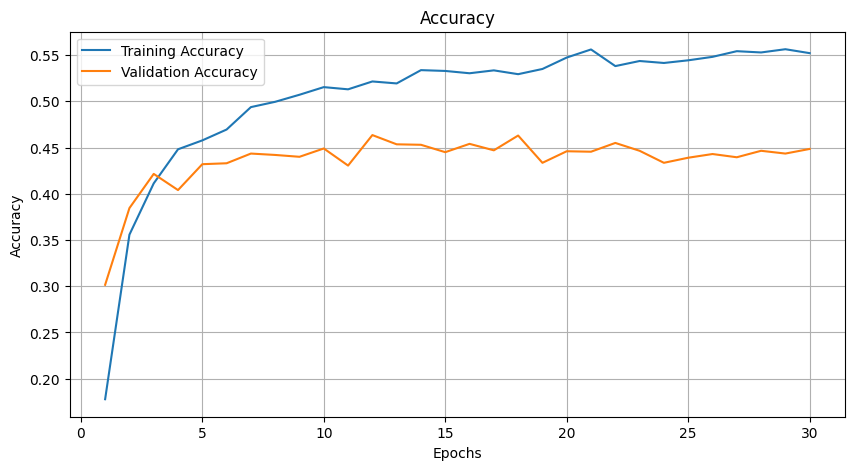

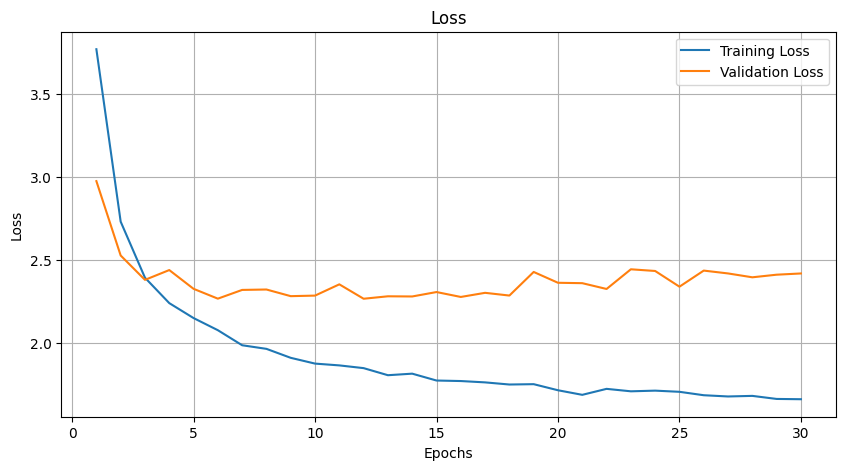

In [11]:
plot_history(train_losses, val_losses, train_accuracies, val_accuracies)


Epoch [1/30]: 100%|██████████| 250/250 [00:45<00:00,  5.44it/s, Batch Loss=1.6, Running Loss=1.71, Accuracy=54.6]


Fine-Tune Epoch 1/30
Train Loss: 1.7108, Train Acc: 0.5460
Val Loss: 2.3441, Val Acc: 0.4595


Epoch [2/30]: 100%|██████████| 250/250 [00:45<00:00,  5.47it/s, Batch Loss=1.33, Running Loss=1.64, Accuracy=55.7]


Fine-Tune Epoch 2/30
Train Loss: 1.6446, Train Acc: 0.5574
Val Loss: 2.4263, Val Acc: 0.4365


Epoch [3/30]: 100%|██████████| 250/250 [00:45<00:00,  5.46it/s, Batch Loss=2.03, Running Loss=1.66, Accuracy=55.1]


Fine-Tune Epoch 3/30
Train Loss: 1.6636, Train Acc: 0.5514
Val Loss: 2.4359, Val Acc: 0.4335


Epoch [4/30]: 100%|██████████| 250/250 [00:45<00:00,  5.49it/s, Batch Loss=1.37, Running Loss=1.66, Accuracy=56.1]


Fine-Tune Epoch 4/30
Train Loss: 1.6551, Train Acc: 0.5614
Val Loss: 2.4055, Val Acc: 0.4385


Epoch [5/30]: 100%|██████████| 250/250 [00:45<00:00,  5.52it/s, Batch Loss=1.64, Running Loss=1.65, Accuracy=55.6]


Fine-Tune Epoch 5/30
Train Loss: 1.6524, Train Acc: 0.5561
Val Loss: 2.4767, Val Acc: 0.4485


Epoch [6/30]: 100%|██████████| 250/250 [00:45<00:00,  5.50it/s, Batch Loss=1.71, Running Loss=1.66, Accuracy=55.7]


Fine-Tune Epoch 6/30
Train Loss: 1.6564, Train Acc: 0.5569
Val Loss: 2.4827, Val Acc: 0.4370


Epoch [7/30]: 100%|██████████| 250/250 [00:45<00:00,  5.48it/s, Batch Loss=1.62, Running Loss=1.59, Accuracy=56.7]


Fine-Tune Epoch 7/30
Train Loss: 1.5937, Train Acc: 0.5669
Val Loss: 2.3847, Val Acc: 0.4610


Epoch [8/30]: 100%|██████████| 250/250 [00:45<00:00,  5.52it/s, Batch Loss=1.53, Running Loss=1.62, Accuracy=56.3]


Fine-Tune Epoch 8/30
Train Loss: 1.6239, Train Acc: 0.5627
Val Loss: 2.4172, Val Acc: 0.4465


Epoch [9/30]: 100%|██████████| 250/250 [00:45<00:00,  5.45it/s, Batch Loss=2.03, Running Loss=1.62, Accuracy=56.6]


Fine-Tune Epoch 9/30
Train Loss: 1.6203, Train Acc: 0.5659
Val Loss: 2.3914, Val Acc: 0.4505


Epoch [10/30]: 100%|██████████| 250/250 [00:46<00:00,  5.42it/s, Batch Loss=1.56, Running Loss=1.65, Accuracy=55.8]


Fine-Tune Epoch 10/30
Train Loss: 1.6522, Train Acc: 0.5581
Val Loss: 2.3965, Val Acc: 0.4565


Epoch [11/30]: 100%|██████████| 250/250 [00:46<00:00,  5.37it/s, Batch Loss=1.15, Running Loss=1.6, Accuracy=57]


Fine-Tune Epoch 11/30
Train Loss: 1.5951, Train Acc: 0.5696
Val Loss: 2.3891, Val Acc: 0.4575


Epoch [12/30]: 100%|██████████| 250/250 [00:46<00:00,  5.43it/s, Batch Loss=1.6, Running Loss=1.62, Accuracy=56.9]


Fine-Tune Epoch 12/30
Train Loss: 1.6174, Train Acc: 0.5693
Val Loss: 2.3829, Val Acc: 0.4475


Epoch [13/30]: 100%|██████████| 250/250 [00:46<00:00,  5.34it/s, Batch Loss=2.27, Running Loss=1.6, Accuracy=56.5]


Fine-Tune Epoch 13/30
Train Loss: 1.6027, Train Acc: 0.5653
Val Loss: 2.4726, Val Acc: 0.4460


Epoch [14/30]: 100%|██████████| 250/250 [00:46<00:00,  5.33it/s, Batch Loss=1.57, Running Loss=1.62, Accuracy=56.6]


Fine-Tune Epoch 14/30
Train Loss: 1.6200, Train Acc: 0.5664
Val Loss: 2.4267, Val Acc: 0.4595


Epoch [15/30]: 100%|██████████| 250/250 [00:46<00:00,  5.37it/s, Batch Loss=1.66, Running Loss=1.62, Accuracy=56.7]


Fine-Tune Epoch 15/30
Train Loss: 1.6189, Train Acc: 0.5671
Val Loss: 2.4855, Val Acc: 0.4400


Epoch [16/30]: 100%|██████████| 250/250 [00:49<00:00,  5.04it/s, Batch Loss=1.61, Running Loss=1.63, Accuracy=56.8]


Fine-Tune Epoch 16/30
Train Loss: 1.6254, Train Acc: 0.5675
Val Loss: 2.3547, Val Acc: 0.4650
Saved best finetuned model!


Epoch [17/30]: 100%|██████████| 250/250 [00:48<00:00,  5.12it/s, Batch Loss=1.51, Running Loss=1.64, Accuracy=55.6]


Fine-Tune Epoch 17/30
Train Loss: 1.6401, Train Acc: 0.5563
Val Loss: 2.5250, Val Acc: 0.4280


Epoch [18/30]: 100%|██████████| 250/250 [00:46<00:00,  5.33it/s, Batch Loss=1.25, Running Loss=1.61, Accuracy=56.4]


Fine-Tune Epoch 18/30
Train Loss: 1.6123, Train Acc: 0.5643
Val Loss: 2.4595, Val Acc: 0.4440


Epoch [19/30]: 100%|██████████| 250/250 [00:47<00:00,  5.29it/s, Batch Loss=2.08, Running Loss=1.62, Accuracy=56.8]


Fine-Tune Epoch 19/30
Train Loss: 1.6202, Train Acc: 0.5683
Val Loss: 2.4763, Val Acc: 0.4425


Epoch [20/30]: 100%|██████████| 250/250 [00:50<00:00,  4.95it/s, Batch Loss=1.98, Running Loss=1.62, Accuracy=56.4]


Fine-Tune Epoch 20/30
Train Loss: 1.6246, Train Acc: 0.5643
Val Loss: 2.4845, Val Acc: 0.4405


Epoch [21/30]: 100%|██████████| 250/250 [00:48<00:00,  5.15it/s, Batch Loss=1.1, Running Loss=1.58, Accuracy=57.4]


Fine-Tune Epoch 21/30
Train Loss: 1.5788, Train Acc: 0.5737
Val Loss: 2.4603, Val Acc: 0.4465


Epoch [22/30]: 100%|██████████| 250/250 [00:49<00:00,  5.05it/s, Batch Loss=1.76, Running Loss=1.6, Accuracy=57]


Fine-Tune Epoch 22/30
Train Loss: 1.5966, Train Acc: 0.5699
Val Loss: 2.3837, Val Acc: 0.4590


Epoch [23/30]: 100%|██████████| 250/250 [00:48<00:00,  5.20it/s, Batch Loss=1.85, Running Loss=1.58, Accuracy=57]


Fine-Tune Epoch 23/30
Train Loss: 1.5838, Train Acc: 0.5704
Val Loss: 2.4234, Val Acc: 0.4525


Epoch [24/30]: 100%|██████████| 250/250 [00:47<00:00,  5.24it/s, Batch Loss=2.07, Running Loss=1.6, Accuracy=57.5]


Fine-Tune Epoch 24/30
Train Loss: 1.6047, Train Acc: 0.5754
Val Loss: 2.4699, Val Acc: 0.4425


Epoch [25/30]: 100%|██████████| 250/250 [00:45<00:00,  5.52it/s, Batch Loss=1.65, Running Loss=1.58, Accuracy=57.1]


Fine-Tune Epoch 25/30
Train Loss: 1.5831, Train Acc: 0.5706
Val Loss: 2.5069, Val Acc: 0.4365


Epoch [26/30]: 100%|██████████| 250/250 [00:45<00:00,  5.47it/s, Batch Loss=1.23, Running Loss=1.56, Accuracy=58.3]


Fine-Tune Epoch 26/30
Train Loss: 1.5554, Train Acc: 0.5833
Val Loss: 2.5214, Val Acc: 0.4365


Epoch [27/30]: 100%|██████████| 250/250 [00:45<00:00,  5.45it/s, Batch Loss=1.16, Running Loss=1.6, Accuracy=56.6]


Fine-Tune Epoch 27/30
Train Loss: 1.5954, Train Acc: 0.5663
Val Loss: 2.4705, Val Acc: 0.4380


Epoch [28/30]: 100%|██████████| 250/250 [00:45<00:00,  5.49it/s, Batch Loss=1.9, Running Loss=1.58, Accuracy=57.2]


Fine-Tune Epoch 28/30
Train Loss: 1.5807, Train Acc: 0.5725
Val Loss: 2.4682, Val Acc: 0.4450


Epoch [29/30]: 100%|██████████| 250/250 [00:45<00:00,  5.49it/s, Batch Loss=1.13, Running Loss=1.61, Accuracy=57.3]


Fine-Tune Epoch 29/30
Train Loss: 1.6103, Train Acc: 0.5733
Val Loss: 2.4797, Val Acc: 0.4555


Epoch [30/30]: 100%|██████████| 250/250 [00:45<00:00,  5.53it/s, Batch Loss=0.997, Running Loss=1.58, Accuracy=57.4]


Fine-Tune Epoch 30/30
Train Loss: 1.5777, Train Acc: 0.5739
Val Loss: 2.5056, Val Acc: 0.4485


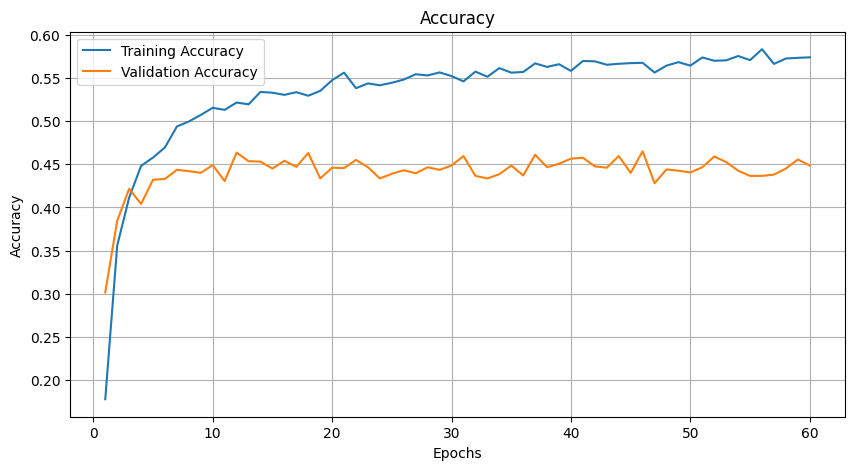

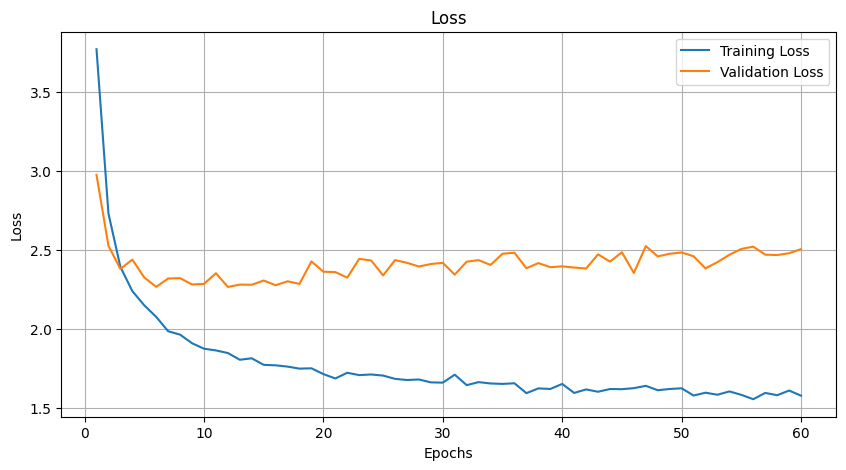

In [12]:
# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze the last layers (modify based on ResNet structure)
for param in model.classifier.parameters():
    param.requires_grad = True


# Reinitialize the optimizer for fine-tuning
optimizer = optim.Adam(model.classifier.parameters(), lr=1e-3)

# Fine-tuning loop
fine_tune_epochs = 30
for epoch in range(1, fine_tune_epochs + 1):  # Start from 1 for better logs
    train_loss, train_acc = train_one_epoch(model, train_loader, criterion, optimizer, epoch, fine_tune_epochs)
    val_loss, val_acc = evaluate(model, test_loader, criterion)

    # Append metrics
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f"Fine-Tune Epoch {epoch}/{fine_tune_epochs}")
    print(f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")

    # Save the best model checkpoint
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'best_acc': best_acc
        }, "best_model_finetuned.pth")
        print("Saved best finetuned model!")

# Plot the training and validation history
plot_history(train_losses, val_losses, train_accuracies, val_accuracies)


In [13]:
from PIL import Image

def predict_image(image_path, model, class_labels):
    model.eval()
    img = Image.open(image_path).convert("RGB")

    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
    ])

    img_tensor = transform(img).unsqueeze(0).to(device)  # Prepare tensor
    with torch.no_grad():  # disable gradient computation stuff
        outputs = model(img_tensor)  # Predict
        _, predicted_index = outputs.max(1)  # Get the class index
    return class_labels[predicted_index.item()]

### **Prediction of 3 Random Images from Dataset**

In [18]:
from torchvision.transforms.functional import to_pil_image
import matplotlib.pyplot as plt

def show_and_predict_dataset_images(dataset, model, class_labels, num_images=3):
    model.eval()

    selected_indexes= random.sample(range(len(dataset)), num_images)
    selected_samples = [dataset[index] for index in selected_indexes]

    #Prep the figure for showing images
    fig, axs = plt.subplots(1, num_images, figsize=(15, 5))

    for i, (image, true_label) in enumerate(selected_samples):
        # Convert tensor to PIL image so we can see it. Denormalizes it
        img_pil = to_pil_image(image * torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1) +
                       torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1))  # Denormalize inline


        #prediction
        with torch.no_grad():
            image = image.unsqueeze(0).to(device)  #Add batch dimension and move to device (if cuda)
            outputs = model(image)
            _, predicted_idx = outputs.max(1)
            predicted_label = class_labels[predicted_idx.item()]

        axs[i].imshow(img_pil)
        axs[i].set_title(f"Prediction: {predicted_label}\nTruth: {class_labels[true_label]}")
        axs[i].axis("off")

    plt.tight_layout()
    plt.show()


<ipython-input-21-cc22fe550706>:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/content/best_model_finetuned.pth", map_location=device)


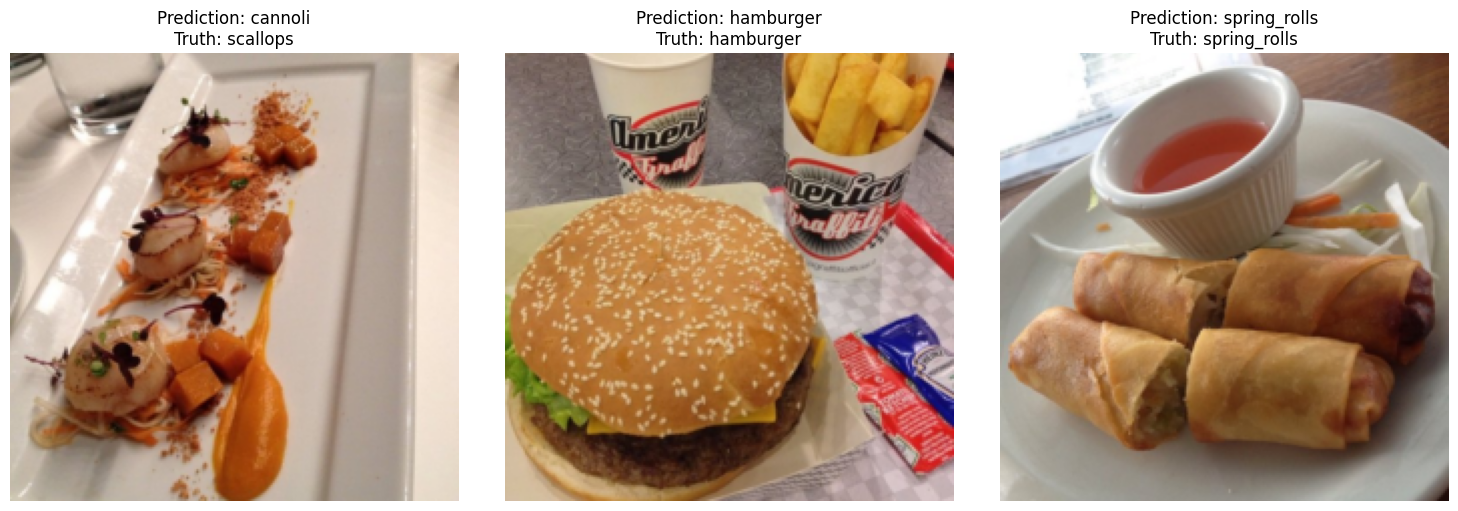

In [21]:
classes = test_dataset.classes
num_classes = len(classes)


model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

# Load the saved checkpoint
checkpoint = torch.load("/content/best_model_finetuned.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()
show_and_predict_dataset_images(test_dataset, model, classes, num_images=3)


### **Prediction of 3 Random Images from Google**

In [29]:
import torch
from torchvision import models, transforms
from PIL import Image

num_classes = 101

classes = train_dataset.classes

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = models.mobilenet_v2(pretrained=False)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, num_classes)
model = model.to(device)

# Load the model
checkpoint = torch.load("/content/best_model_finetuned.pth", map_location=device)
model.load_state_dict(checkpoint['model_state_dict'])
model.eval()


pred_class = predict_image("/content/cake.jpg", model, classes)
print("Predicted class:", pred_class)
getMacros(pred_class)


pred_class = predict_image("/content/baklava.jpg", model, classes)
print("Predicted class:", pred_class)
getMacros(pred_class)

pred_class = predict_image("/content/breakfastburrito.webp", model, classes)
print("Predicted class:", pred_class)
getMacros(pred_class)


Predicted class: red_velvet_cake
Macronutrients for one serving of red_velvet_cake: {'calories': 350, 'protein': 5, 'carbs': 55, 'fat': 15}
Predicted class: baklava
Macronutrients for one serving of baklava: {'calories': 330, 'protein': 4, 'carbs': 34, 'fat': 20}
Predicted class: spaghetti_carbonara
Macronutrients for one serving of spaghetti_carbonara: {'calories': 600, 'protein': 25, 'carbs': 75, 'fat': 25}


<ipython-input-29-98968f3ca858>:16: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load("/content/best_model_finetuned.pth", map_location=device)


{'calories': 600, 'protein': 25, 'carbs': 75, 'fat': 25}

##**Predicting Macros**

In [28]:
food_macros = {
    'apple_pie': {'calories': 320, 'protein': 2, 'carbs': 51, 'fat': 14},
    'baby_back_ribs': {'calories': 400, 'protein': 30, 'carbs': 8, 'fat': 30},
    'baklava': {'calories': 330, 'protein': 4, 'carbs': 34, 'fat': 20},
    'beef_carpaccio': {'calories': 250, 'protein': 30, 'carbs': 0, 'fat': 15},
    'beef_tartare': {'calories': 200, 'protein': 26, 'carbs': 0, 'fat': 10},
    'beet_salad': {'calories': 180, 'protein': 4, 'carbs': 25, 'fat': 8},
    'beignets': {'calories': 250, 'protein': 5, 'carbs': 35, 'fat': 12},
    'bibimbap': {'calories': 500, 'protein': 22, 'carbs': 60, 'fat': 18},
    'bread_pudding': {'calories': 320, 'protein': 6, 'carbs': 50, 'fat': 10},
    'breakfast_burrito': {'calories': 500, 'protein': 25, 'carbs': 45, 'fat': 25},
    'bruschetta': {'calories': 260, 'protein': 8, 'carbs': 35, 'fat': 10},
    'caesar_salad': {'calories': 350, 'protein': 15, 'carbs': 15, 'fat': 25},
    'cannoli': {'calories': 300, 'protein': 5, 'carbs': 30, 'fat': 18},
    'caprese_salad': {'calories': 250, 'protein': 7, 'carbs': 10, 'fat': 20},
    'carrot_cake': {'calories': 400, 'protein': 5, 'carbs': 60, 'fat': 15},
    'ceviche': {'calories': 200, 'protein': 18, 'carbs': 10, 'fat': 5},
    'cheesecake': {'calories': 300, 'protein': 6, 'carbs': 32, 'fat': 18},
    'cheese_plate': {'calories': 450, 'protein': 25, 'carbs': 5, 'fat': 36},
    'chicken_curry': {'calories': 420, 'protein': 30, 'carbs': 20, 'fat': 28},
    'chicken_quesadilla': {'calories': 350, 'protein': 20, 'carbs': 30, 'fat': 15},
    'chicken_wings': {'calories': 400, 'protein': 30, 'carbs': 0, 'fat': 28},
    'chocolate_cake': {'calories': 350, 'protein': 5, 'carbs': 55, 'fat': 15},
    'chocolate_mousse': {'calories': 280, 'protein': 4, 'carbs': 28, 'fat': 18},
    'churros': {'calories': 200, 'protein': 2, 'carbs': 36, 'fat': 8},
    'clam_chowder': {'calories': 200, 'protein': 15, 'carbs': 20, 'fat': 8},
    'club_sandwich': {'calories': 450, 'protein': 25, 'carbs': 36, 'fat': 22},
    'crab_cakes': {'calories': 200, 'protein': 15, 'carbs': 10, 'fat': 12},
    'creme_brulee': {'calories': 350, 'protein': 5, 'carbs': 30, 'fat': 20},
    'croque_madame': {'calories': 500, 'protein': 25, 'carbs': 40, 'fat': 30},
    'cup_cakes': {'calories': 350, 'protein': 3, 'carbs': 55, 'fat': 14},
    'deviled_eggs': {'calories': 200, 'protein': 12, 'carbs': 2, 'fat': 16},
    'donuts': {'calories': 300, 'protein': 3, 'carbs': 38, 'fat': 15},
    'dumplings': {'calories': 250, 'protein': 10, 'carbs': 35, 'fat': 7},
    'edamame': {'calories': 200, 'protein': 18, 'carbs': 14, 'fat': 8},
    'eggs_benedict': {'calories': 400, 'protein': 20, 'carbs': 30, 'fat': 24},
    'escargots': {'calories': 150, 'protein': 22, 'carbs': 0, 'fat': 7},
    'falafel': {'calories': 320, 'protein': 13, 'carbs': 40, 'fat': 15},
    'filet_mignon': {'calories': 400, 'protein': 30, 'carbs': 0, 'fat': 22},
    'fish_and_chips': {'calories': 600, 'protein': 30, 'carbs': 70, 'fat': 25},
    'foie_gras': {'calories': 300, 'protein': 12, 'carbs': 0, 'fat': 28},
    'french_fries': {'calories': 365, 'protein': 4, 'carbs': 63, 'fat': 19},
    'french_onion_soup': {'calories': 250, 'protein': 5, 'carbs': 30, 'fat': 8},
    'french_toast': {'calories': 300, 'protein': 10, 'carbs': 50, 'fat': 10},
    'fried_calamari': {'calories': 300, 'protein': 10, 'carbs': 20, 'fat': 20},
    'fried_rice': {'calories': 350, 'protein': 10, 'carbs': 55, 'fat': 12},
    'frozen_yogurt': {'calories': 150, 'protein': 4, 'carbs': 30, 'fat': 1},
    'garlic_bread': {'calories': 250, 'protein': 6, 'carbs': 31, 'fat': 12},
    'gnocchi': {'calories': 250, 'protein': 8, 'carbs': 50, 'fat': 2},
    'greek_salad': {'calories': 200, 'protein': 5, 'carbs': 10, 'fat': 15},
    'grilled_cheese_sandwich': {'calories': 300, 'protein': 12, 'carbs': 30, 'fat': 18},
    'grilled_salmon': {'calories': 300, 'protein': 30, 'carbs': 0, 'fat': 20},
    'guacamole': {'calories': 230, 'protein': 3, 'carbs': 12, 'fat': 22},
    'gyoza': {'calories': 100, 'protein': 4, 'carbs': 16, 'fat': 4},
    'hamburger': {'calories': 354, 'protein': 17, 'carbs': 32, 'fat': 22},
    'hot_and_sour_soup': {'calories': 100, 'protein': 6, 'carbs': 10, 'fat': 4},
    'hot_dog': {'calories': 150, 'protein': 5, 'carbs': 2, 'fat': 13},
    'huevos_rancheros': {'calories': 300, 'protein': 15, 'carbs': 30, 'fat': 15},
    'hummus': {'calories': 200, 'protein': 8, 'carbs': 25, 'fat': 10},
    'ice_cream': {'calories': 200, 'protein': 4, 'carbs': 30, 'fat': 10},
    'lasagna': {'calories': 450, 'protein': 25, 'carbs': 50, 'fat': 20},
    'lobster_bisque': {'calories': 350, 'protein': 15, 'carbs': 18, 'fat': 25},
    'lobster_roll_sandwich': {'calories': 500, 'protein': 25, 'carbs': 30, 'fat': 30},
    'macaroni_and_cheese': {'calories': 300, 'protein': 10, 'carbs': 45, 'fat': 12},
    'macarons': {'calories': 100, 'protein': 1, 'carbs': 15, 'fat': 4},
    'miso_soup': {'calories': 40, 'protein': 3, 'carbs': 6, 'fat': 1},
    'mussels': {'calories': 150, 'protein': 20, 'carbs': 10, 'fat': 4},
    'nachos': {'calories': 420, 'protein': 12, 'carbs': 56, 'fat': 22},
    'omelette': {'calories': 150, 'protein': 10, 'carbs': 2, 'fat': 11},
    'onion_rings': {'calories': 300, 'protein': 4, 'carbs': 48, 'fat': 14},
    'oysters': {'calories': 50, 'protein': 6, 'carbs': 2, 'fat': 2},
    'pad_thai': {'calories': 400, 'protein': 18, 'carbs': 70, 'fat': 12},
    'paella': {'calories': 400, 'protein': 25, 'carbs': 45, 'fat': 15},
    'pancakes': {'calories': 350, 'protein': 8, 'carbs': 50, 'fat': 14},
    'panna_cotta': {'calories': 250, 'protein': 4, 'carbs': 30, 'fat': 12},
    'peking_duck': {'calories': 500, 'protein': 25, 'carbs': 15, 'fat': 38},
    'pho': {'calories': 350, 'protein': 25, 'carbs': 50, 'fat': 10},
    'pizza': {'calories': 285, 'protein': 12, 'carbs': 36, 'fat': 10},
    'pork_chop': {'calories': 350, 'protein': 30, 'carbs': 0, 'fat': 22},
    'poutine': {'calories': 600, 'protein': 15, 'carbs': 70, 'fat': 36},
    'prime_rib': {'calories': 450, 'protein': 40, 'carbs': 0, 'fat': 30},
    'pulled_pork_sandwich': {'calories': 400, 'protein': 25, 'carbs': 40, 'fat': 20},
    'ramen': {'calories': 400, 'protein': 20, 'carbs': 50, 'fat': 15},
    'ravioli': {'calories': 300, 'protein': 12, 'carbs': 40, 'fat': 10},
    'red_velvet_cake': {'calories': 350, 'protein': 5, 'carbs': 55, 'fat': 15},
    'risotto': {'calories': 350, 'protein': 10, 'carbs': 60, 'fat': 10},
    'samosa': {'calories': 200, 'protein': 5, 'carbs': 30, 'fat': 10},
    'sashimi': {'calories': 100, 'protein': 20, 'carbs': 0, 'fat': 5},
    'scallops': {'calories': 250, 'protein': 36, 'carbs': 5, 'fat': 10},
    'seaweed_salad': {'calories': 70, 'protein': 1, 'carbs': 14, 'fat': 2},
    'shrimp_and_grits': {'calories': 400, 'protein': 25, 'carbs': 55, 'fat': 15},
    'spaghetti_bolognese': {'calories': 500, 'protein': 20, 'carbs': 70, 'fat': 15},
    'spaghetti_carbonara': {'calories': 600, 'protein': 25, 'carbs': 75, 'fat': 25},
    'spring_rolls': {'calories': 200, 'protein': 5, 'carbs': 30, 'fat': 8},
    'steak': {'calories': 450, 'protein': 40, 'carbs': 0, 'fat': 30},
    'strawberry_shortcake': {'calories': 350, 'protein': 5, 'carbs': 60, 'fat': 12},
    'sushi': {'calories': 200, 'protein': 8, 'carbs': 40, 'fat': 2},
    'tacos': {'calories': 250, 'protein': 15, 'carbs': 20, 'fat': 12},
    'takoyaki': {'calories': 250, 'protein': 10, 'carbs': 30, 'fat': 12},
    'tiramisu': {'calories': 400, 'protein': 6, 'carbs': 46, 'fat': 26},
    'tuna_tartare': {'calories': 150, 'protein': 20, 'carbs': 0, 'fat': 7},
    'waffles': {'calories': 300, 'protein': 8, 'carbs': 50, 'fat': 12},
}
def getMacros(food):
      macros = food_macros.get(food.lower(), None)
      if macros:
        print(f'Macronutrients for one serving of {food}: {macros}')
        return macros
      else:
        print("Food item not found.")
        return None